# Chemical Kinetics

> Find Steady State and time dependent concentrations of species

In [ ]:
#| default_exp kinetics

In [ ]:
#| export
#| echo: false
import os
import re
import linecache
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

In [ ]:
#| export
def steady_state_calc(rates):
    """
    Calculate the steady state equilibrium of reaction a<->b<->c, given the rate of the forwards and backwards processes at each step
    """
    kf1 = rates[0]
    kr1 = rates[1]
    kf2 = rates[2]
    kr2 = rates[3]
    mat = np.array([[-kf1,kr1,0],[0,kf2,-kr2],[1,1,1]])
    vec = np.array([0,0,1])
    mat_inv = np.linalg.inv(mat)
    out = np.matmul(mat_inv, vec)
    return out

For instance, for varying concentrations of urea:

Consider the reaction

$$D  \xrightleftharpoons[k_{u}^{R15}]{k_{f}^{R15}}  I  \xrightleftharpoons[k_{u}^{R16}]{k_{f}^{R16}} N$$

In the steady state, the rate of change of all components it null and so

$$k_{u}^{R15}[I]-k_{f}^{R15}[D]=0$$
$$k_{f}^{R16}[I]-k_{u}^{R16}[N]=0$$

and with an additional restriction that the total number of substances is constant: wlg let that be 1:

$$[D]+[I]+[N]=1$$

As such this can be represented as a matrix:

$$\begin{pmatrix}-k_{f}^{R15}&k_{u}^{R15}&0\\ 0 & k_{f}^{R16} & -k_{u}^{R16}\\ 1&1&1\end{pmatrix}\begin{pmatrix} [D] \\ [I] \\ [N] \end{pmatrix} = \begin{pmatrix} 0 \\ 0 \\ 1 \end{pmatrix}$$

And thus

$$\begin{pmatrix} [D] \\ [I] \\ [N] \end{pmatrix} = \frac{1}{k_{f}^{R15}k_{f}^{R16}+k_{f}^{R15}k_{u}^{R16}+k_{u}^{R15}k_{u}^{R16}}\begin{pmatrix}-k_{f}^{R16}-k_{u}^{R16}&k_{u}^{R15}&k_{u}^{R15}k_{u}^{R16}\\ k_{u}^{R16} & k_{f}^{R15} & k_{f}^{R15}k_{u}^{R16}\\ k_{f}^{R16}&-k_{f}^{R15}-k_{u}^{R15}&k_{f}^{R15}k_{f}^{R16}\end{pmatrix}\begin{pmatrix} 0 \\ 0 \\ 1 \end{pmatrix}$$

In [ ]:
kf1 = 26000
kr1 = 0.06
kf2 = 730
kr2 = 0.00075
urea_conc = np.linspace(0, 8, num=1000)
ss_conc = []
for conc in urea_conc:
    rates = [kf1*np.exp(-1.68*conc), kr1*np.exp(0.95*conc), kf2*np.exp(-1.72*conc), kr2*np.exp(1.20*conc)]
    ss_conc.append(steady_state_calc(rates))


In [ ]:
ss_conc = np.array(ss_conc)

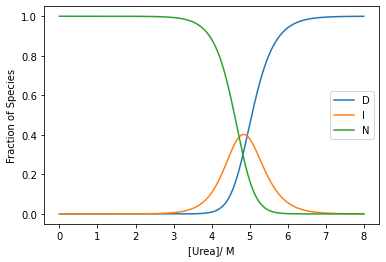

In [ ]:
plt.plot(urea_conc,ss_conc[:, 0],label='D')
plt.plot(urea_conc,ss_conc[:, 1],label='I')
plt.plot(urea_conc,ss_conc[:, 2],label='N')
plt.xlabel('[Urea]/ M')
plt.ylabel('Fraction of Species')
plt.legend()
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()